# オープンデータのみを使用し業績開示後に見るべき指標と株価への織り込み時期を探る

## 目的
個別銘柄の株価が大きく動くのは業績開示後であると仮定し、**特にどんな数字を重要視し、何日以内にピークに達するか**を株価変動率から考察します。継続して高値や安値を更新する場合もありますが、動きの激しい期間（≒流動性が十分に保たれる期間）に利確することを志向しています。

## 注意事項
- 完全なシステムトレードを目指したものではなく、「開示の確認箇所を明らかにし査読時間を短縮する」「時間軸や指値位置等、売買戦略に活かす」ことを目的としています。システムトレードには板情報や歩み値が必須と思っており、それらを収集しなければリスクリワードが悪いと個人的に思っています。（小声）
- 本コードは投資を指南・推薦するものではありません。自己責任でのご利用をお願いします。


## 使用するデータ
いずれも2022年末時点では無料で取得できます。
1. 日足出来高と四本値（始値、終値、高値、安値）：APIを叩いて収集しておきます。特徴量と目的変数の両方に使用します。[yahoo_finance_api2](https://pypi.org/project/yahoo-finance-api2/)取得方法の詳細はこちら[【日本株】全銘柄の四本値をPKGから取得し日次で更新する]
2. 財務データ：J-Quantsに会員登録して収集します。[J-Quants API](https://application.jpx-jquants.com/)[公式サイト](https://jpx.gitbook.io/j-quants-api/api-reference/finance-api)に収集方法の詳細が説明されているのでここでは割愛します。
3. 銘柄コードデータ：JPXのサイトからダウンロードします。[JPX](https://www.jpx.co.jp/markets/statistics-equities/misc/tvdivq0000001vg2-att/data_j.xls)
各種データの期間は、財務データAPIの最古日（本notebook作成時で2017-02-10）から最新のデータを取得しています。

## 処理の概要
1. データの準備
    - 年毎にcsvファイルを分けて保存している日足データを結合します。
    - 目的変数を「{(基準日からN営業日間における高値または安値) / (基準日の終値)} - 1」とし四本値を加工します。
    - 銘柄コードデータを利用し、今回対象外となるETF、REIT等のデータを除外します。
    - 日足出来高と四本値を利用し、売買代金の大小から４つに分類します。←売買代金が少ないものは予測が困難ではないかと仮定し、除去して予測してみるため。
    - 日足データが揃わないもの（≒上場して間もないものや上場廃止となった可能性があるもの等）を除外します。
2. EDA
    - 財務データの代表的な特徴量による散布図行列。
    - 財務データを複数銘柄で比較。
    - 株価とその移動平均の折れ線グラフ。
    - 株価変化率の折れ線グラフ。
    - 株価のヒストリカルボラティリティ。[ヒストリカルボラティリティとは](https://www.jpx.co.jp/glossary/ha/382.html)
    - 欠損値の確認と補完
3. データの前処理
    - 目的変数を開示日に絞る
    - 特徴量作成
4. バックテスト準備
    - train/val/test期間の設定（ホールドアウト法）
5. 予測
    - 目的変数ごとにtrain/val/testを作成
    - RandomForest
    - XGBoost
    - ExtraTrees
    - GBR
    - 各種評価指標の出力
    
## 結果と所感
### 業績開示で注目すべき指標
個人投資家に注目されがちなのはEPSや配当である感覚があるが、どのモデルでもEquity（純資産）、TotalAssets（総資産）が高いため、**株式数によらず**資産の大小が価格変動率に影響を与えることがわかります。また、日足の特徴量を加えると、2,3か月の価格変動率の影響が特にプラスの場合に顕著に出ることがわかります。前回の業績開示により株価が上がった場合、次の業績開示でも上に動きやすいのかもしれません。一方で、出来高はマイナスへの影響が比較的大きく、出来高が小さい場合に、株価が下へ動く圧力が高いように見えます。
所感としては、マーケットメーカーの注文が資産の大きい大型株に集まるため変動率が顕著になり、対して小型株はものによっては大型よりも大きな変動率を付けるもののバラつきが激しいため全体としての変動率は大きくはならず、EPSよりも資産の方が影響度として強く出るのではないかと思います。

### 業績開示の影響は何日で織り込むか
目的変数のN日数に注目します。10日間の高値変動率と20日間の高値価格変動率が、その他と比較しどの評価指標でも高くなっています。この二つでの比較ではさほど値は変わらないため、金利や手数料、地合いとのバランスでどちらかの予測を採用するのが良いのではと思います。また、銘柄の流動性≒売買代金を鑑みるためその４区分で対象データを絞り込み比較すると、以下の通りx-largeのみが最も各種評価指標が高く、特に20日間の高値変動率が高くなっています。売買代金が低い分類も対象にする程、精度が悪い結果となりました。
- x-large, largeのみ（本ノート）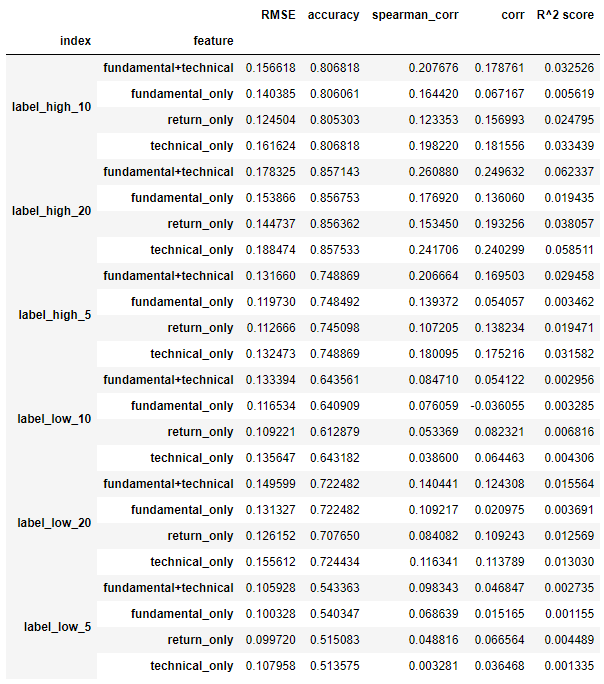
- x-largeのみ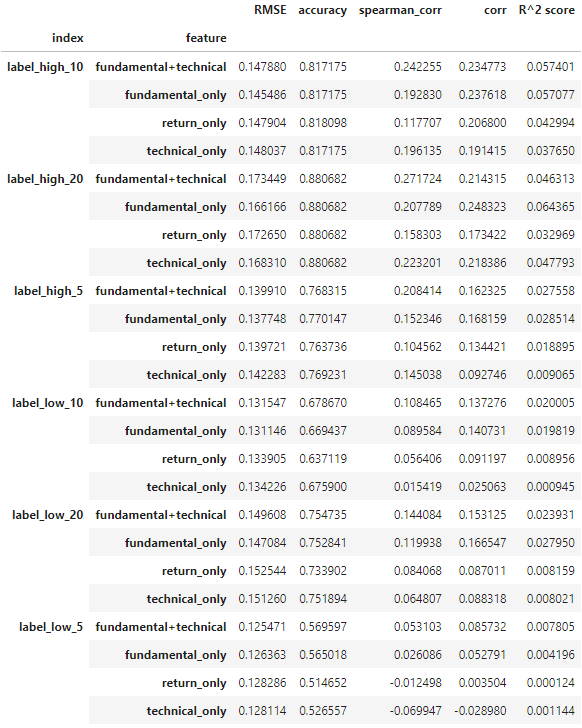
- smallのみ除外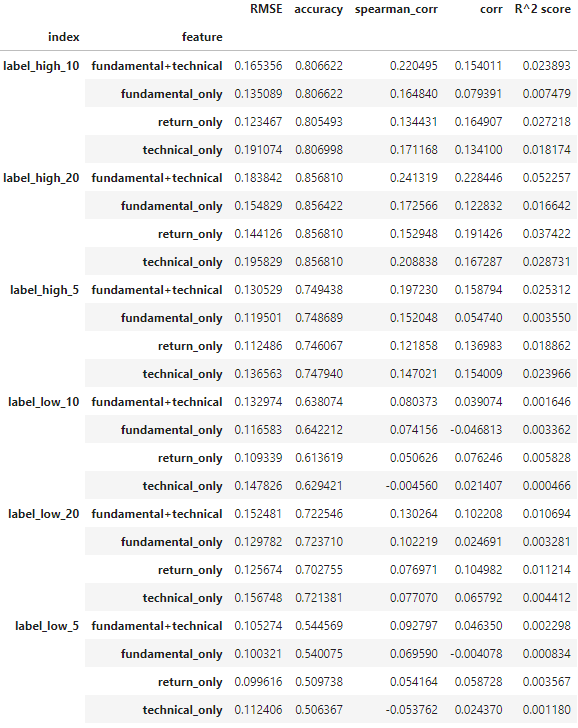
- すべて対象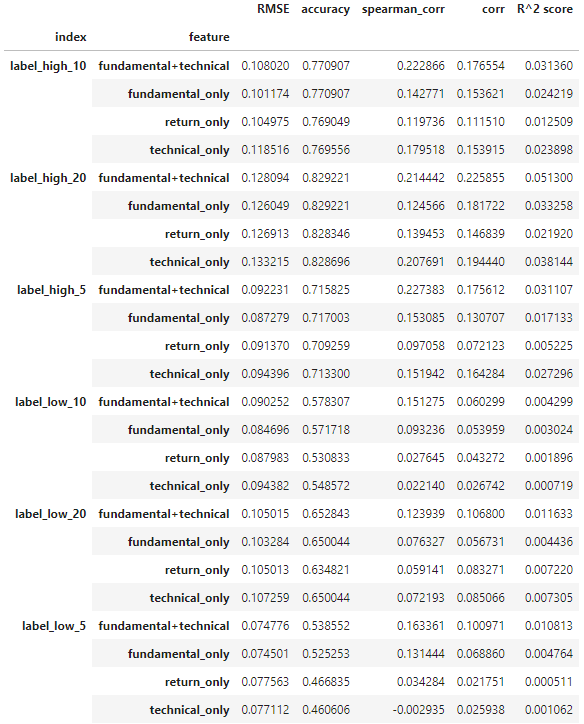

### 今後に向けて
- 売買代金による４区分でもモデルの精度が異なるため、業種やβ等による区分でも精度が異なるのではないかと想定されます。より精度が高い分類が見つかれば、比較的予測しやすい銘柄コードとして優位性の高い取引ができるのではないかと考えます。
- 株価により影響を与えるものとして、前期開示からの増減率や貸借情報等と想定されるため、データを作成して追加してみたいと思います。

In [1]:
import os
import pickle
import sys
import warnings
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr
import shap
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm.auto import tqdm
import xgboost


# 表示用の設定を変更します
%matplotlib inline

C:\Users\ytomi\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# データの準備
## 日足データ

In [2]:
# 最新の四本値をインポート
list_of_files = glob('*_daily_value.csv') 
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)

price = pd.read_csv(latest_file, index_col = 0)
price['code'] = price['code'].astype('int64')
price.index = pd.to_datetime(price.index)
price.tail()

230106_daily_value.csv


,High,Low,Open,Close,Volume,Adj Close,code
2023-01-06,1286.0,1270.0,1283.0,1283.0,6100.0,0.0,9993
2023-01-06,2500.0,2480.0,2480.0,2496.0,2900.0,0.0,9994
2023-01-06,423.0,418.0,418.0,423.0,26400.0,0.0,9995
2023-01-06,1145.0,1132.0,1142.0,1142.0,1500.0,0.0,9996
2023-01-06,673.0,669.0,670.0,672.0,78500.0,0.0,9997


In [3]:
%%time
price20 = pd.read_csv('2020_daily_value.csv', index_col = 0)
price20.index = pd.to_datetime(price20.index)
price19 = pd.read_csv('2019_daily_value.csv', index_col = 0)
price19.index = pd.to_datetime(price19.index)
price18 = pd.read_csv('2018_daily_value.csv', index_col = 0)
price18.index = pd.to_datetime(price18.index)
price17 = pd.read_csv('2017_daily_value.csv', index_col = 0)
price17.index = pd.to_datetime(price17.index)
price16 = pd.read_csv('2016_daily_value.csv', index_col = 0)
price16.index = pd.to_datetime(price16.index)

Wall time: 4.53 s


In [4]:
price =  pd.concat([price, price20], axis = 0)
price =  pd.concat([price, price19], axis = 0)
price =  pd.concat([price, price18], axis = 0)
price =  pd.concat([price, price17], axis = 0)
price =  pd.concat([price, price16], axis = 0)
price['code'] = price['code'].astype('int64')
price.sort_index(inplace = True)
price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5946583 entries, 2016-01-04 to 2023-01-06
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   High       float64
 1   Low        float64
 2   Open       float64
 3   Close      float64
 4   Volume     float64
 5   Adj Close  float64
 6   code       int64  
dtypes: float64(6), int64(1)
memory usage: 363.0 MB


In [5]:
price.index.min()

Timestamp('2016-01-04 00:00:00')

## 目的変数の作成

In [6]:
stock_labels = price[['code', 'Close', 'High', 'Low']].copy()
stock_labels['label_date_5'] = stock_labels.index + pd.offsets.BDay(5)
stock_labels.head()

,code,Close,High,Low,label_date_5
2016-01-04,2659,5340.0,5530.0,5330.0,2016-01-11
2016-01-04,5411,1921.0,1985.0,1900.5,2016-01-11
2016-01-04,7298,1114.0,1132.0,1110.0,2016-01-11
2016-01-04,5423,755.0,774.0,742.0,2016-01-11
2016-01-04,2762,925.0,930.0,925.0,2016-01-11


In [7]:
columns = ['code', 'label_date_5', 'label_high_5', 'label_low_5', 'label_date_10', 'label_high_10', 'label_low_10', 'label_date_20', 'label_high_20', 'label_low_20']
stock_labels = pd.DataFrame(columns=columns)
stock_labels

,code,label_date_5,label_high_5,label_low_5,label_date_10,label_high_10,label_low_10,label_date_20,label_high_20,label_low_20


In [8]:
%%time
codes = price['code'].unique()
for code in codes:
    
    labels_tmp = price[price['code'] == code].copy()

    labels_tmp['label_date_5'] = labels_tmp.index + pd.offsets.BDay(5)
    labels_tmp['label_date_10'] = labels_tmp.index + pd.offsets.BDay(10)
    labels_tmp['label_date_20'] = labels_tmp.index + pd.offsets.BDay(20)

    n = 5
    labels_tmp['High_5'] = labels_tmp['High'].rolling(n).max().shift(-n)
    labels_tmp['Low_5'] =labels_tmp['Low'].rolling(n).max().shift(-n)
    labels_tmp['label_high_5'] = ( labels_tmp['High_5'] / labels_tmp['Close']) - 1
    labels_tmp['label_low_5'] = ( labels_tmp['Low_5'] / labels_tmp['Close']) - 1

    n = 10
    labels_tmp['High_10'] = labels_tmp['High'].rolling(n).max().shift(-n)
    labels_tmp['Low_10'] =labels_tmp['Low'].rolling(n).max().shift(-n)
    labels_tmp['label_high_10'] = ( labels_tmp['High_10'] / labels_tmp['Close']) - 1
    labels_tmp['label_low_10'] = ( labels_tmp['Low_10'] / labels_tmp['Close']) - 1

    n = 20
    labels_tmp['High_20'] = labels_tmp['High'].rolling(n).max().shift(-n)
    labels_tmp['Low_20'] =labels_tmp['Low'].rolling(n).max().shift(-n)
    labels_tmp['label_high_20'] = ( labels_tmp['High_20'] / labels_tmp['Close']) - 1
    labels_tmp['label_low_20'] = ( labels_tmp['Low_20'] / labels_tmp['Close']) - 1

    stock_labels = pd.concat([stock_labels, labels_tmp[columns]])

Wall time: 25min 26s


In [9]:
stock_labels = pd.read_csv('stock_labels.csv', index_col = 0)
stock_labels.index = pd.to_datetime(stock_labels.index)

In [10]:
stock_labels.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5935419 entries, 2016-01-04 to 2022-12-30
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   code           int64  
 1   label_date_5   object 
 2   label_high_5   float64
 3   label_low_5    float64
 4   label_date_10  object 
 5   label_high_10  float64
 6   label_low_10   float64
 7   label_date_20  object 
 8   label_high_20  float64
 9   label_low_20   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 498.1+ MB


In [11]:
stock_labels.head()

,code,label_date_5,label_high_5,label_low_5,label_date_10,label_high_10,label_low_10,label_date_20,label_high_20,label_low_20
2016-01-04,8107,2016-01-11,0.0,-0.125,2016-01-18,0.0,-0.125,2016-02-01,0.0,-0.125
2016-01-05,8107,2016-01-12,0.0,-0.125,2016-01-19,0.0,-0.125,2016-02-02,0.0,-0.125
2016-01-06,8107,2016-01-13,0.0,-0.125,2016-01-20,0.0,-0.125,2016-02-03,0.0,-0.125
2016-01-07,8107,2016-01-14,0.0,-0.125,2016-01-21,0.0,-0.125,2016-02-04,0.0,-0.125
2016-01-08,8107,2016-01-15,0.0,-0.125,2016-01-22,0.0,-0.125,2016-02-05,0.0,-0.125


In [12]:
stock_labels.tail()

,code,label_date_5,label_high_5,label_low_5,label_date_10,label_high_10,label_low_10,label_date_20,label_high_20,label_low_20
2022-12-26,4447,2023-01-02,NaN,NaN,2023-01-09,NaN,NaN,2023-01-23,NaN,NaN
2022-12-27,4447,2023-01-03,NaN,NaN,2023-01-10,NaN,NaN,2023-01-24,NaN,NaN
2022-12-28,4447,2023-01-04,NaN,NaN,2023-01-11,NaN,NaN,2023-01-25,NaN,NaN
2022-12-29,4447,2023-01-05,NaN,NaN,2023-01-12,NaN,NaN,2023-01-26,NaN,NaN
2022-12-30,4447,2023-01-06,NaN,NaN,2023-01-13,NaN,NaN,2023-01-27,NaN,NaN


## 銘柄コードデータを使用した除外

In [13]:
stock_list = pd.read_excel("./data_j.xls")
stock_list.loc[stock_list["市場・商品区分"]=="市場第一部（内国株）",
              ["コード","銘柄名","33業種コード","33業種区分","規模コード","規模区分"]
             ]
stock_list

,日付,コード,銘柄名,市場・商品区分,33業種コード,33業種区分,17業種コード,17業種区分,規模コード,規模区分
0,20221230,1301,極洋,プライム（内国株式）,50,水産・農林業,1,食品,7,TOPIX Small 2
1,20221230,1305,ダイワ上場投信－トピックス,ETF・ETN,-,-,-,-,-,-
2,20221230,1306,ＮＥＸＴ ＦＵＮＤＳ ＴＯＰＩＸ連動型上場投信,ETF・ETN,-,-,-,-,-,-
3,20221230,1308,上場インデックスファンドＴＯＰＩＸ,ETF・ETN,-,-,-,-,-,-
4,20221230,1309,ＮＥＸＴ ＦＵＮＤＳ ＣｈｉｎａＡＭＣ・中国株式・上証５０連動型上場投信,ETF・ETN,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...
4241,20221230,9993,ヤマザワ,スタンダード（内国株式）,6100,小売業,14,小売,7,TOPIX Small 2
4242,20221230,9994,やまや,スタンダード（内国株式）,6100,小売業,14,小売,7,TOPIX Small 2
4243,20221230,9995,グローセル,プライム（内国株式）,6050,卸売業,13,商社・卸売,7,TOPIX Small 2
4244,20221230,9996,サトー商会,スタンダード（内国株式）,6050,卸売業,13,商社・卸売,-,-


In [14]:
stock_list = stock_list.rename(columns={'コード': 'code', '銘柄名':'Name', '市場・商品区分':'Section/Products',
                                       '33業種コード':'33 Sector(Code)', '33業種区分':'33 Sector(name)', 
                                       '17業種コード':'17 Sector(Code)', '17業種区分':'17 Sector(name)',
                                       '規模コード':'Size Code (New Index Series)', '規模区分':'Size (New Index Series)',
                                       '日付':'IssuedShareEquityQuote ModifyDate'})

直近25日間に絞って売買代金でビニング処理し「'small', 'medium', 'large', 'x-large'」の４つに分類します。売買代金を正確に求めるには「VWAP」が必要ですが、今回用いるAPIに存在しないため、「（始値 + 終値）/ 2 」で代用し、これに出来高を掛けて求めます。

In [15]:
price25 = price[price.index >= price.index.unique()[-25]].copy()

In [16]:
price25['TradeValue'] = (price25['Open'] + price25['Close'])/2 * price25['Volume']
price25['UpDown'] = price25['Close'] - price25['Open']
price25['UpDownRatio'] = price25['Close'] / price25['Open']
np.seterr(divide='ignore')  # 0除算のRuntimeWarningのみを無視扱いとする
price25['UpDownRatioLog'] =np.log10(price25['UpDownRatio'])

# 25間の平均volumeを求める
price25 = price25.groupby('code').mean()
price25.head()

,High,Low,Open,Close,Volume,Adj Close,TradeValue,UpDown,UpDownRatio,UpDownRatioLog
code,,,,,,,,,,
1301,3727.60,3672.20,3702.00,3702.00,14892.0,0.0,55181180.0,0.00,1.000046,-0.000007
1332,534.72,528.04,531.40,531.92,1283880.0,0.0,681675828.0,0.52,1.000995,0.000421
1333,2455.84,2424.16,2442.44,2443.24,156784.0,0.0,383239348.0,0.80,1.000356,0.000143
1375,1001.40,990.76,997.12,995.64,68140.0,0.0,67809324.0,-1.48,0.998552,-0.000644
1376,1430.80,1405.36,1421.36,1417.12,14188.0,0.0,20271090.0,-4.24,0.997147,-0.001280


In [17]:
price25['Volume_bin'] = pd.qcut(price25['TradeValue'], 4, 
                    labels=['small', 'medium', 'large', 'x-large'])
price25.head()

,High,Low,Open,Close,Volume,Adj Close,TradeValue,UpDown,UpDownRatio,UpDownRatioLog,Volume_bin
code,,,,,,,,,,,
1301,3727.60,3672.20,3702.00,3702.00,14892.0,0.0,55181180.0,0.00,1.000046,-0.000007,large
1332,534.72,528.04,531.40,531.92,1283880.0,0.0,681675828.0,0.52,1.000995,0.000421,x-large
1333,2455.84,2424.16,2442.44,2443.24,156784.0,0.0,383239348.0,0.80,1.000356,0.000143,x-large
1375,1001.40,990.76,997.12,995.64,68140.0,0.0,67809324.0,-1.48,0.998552,-0.000644,large
1376,1430.80,1405.36,1421.36,1417.12,14188.0,0.0,20271090.0,-4.24,0.997147,-0.001280,medium


In [18]:
large_v_code = price25[(price25['Volume_bin'] == 'x-large') | (price25['Volume_bin'] == 'large')].index.tolist()
print('売買代金が中央値以上の銘柄数：{}'.format(len(large_v_code)))

売買代金が中央値以上の銘柄数：1903


In [19]:
# 該当期間のデータが不足するもの≒（全期間-20日分未満しかないもの）をカット
x = len(price[price['code'] == 1301].index.unique()) - 20
price_group = price.groupby('code').count()
plentry_list = price_group[price_group['High'] >= x].index
print(len(plentry_list))

stock_list['prediction_target'] = ((stock_list['Section/Products'] == 'プライム（内国株式）') |(stock_list['Section/Products'] == 'スタンダード（内国株式）') | (stock_list['Section/Products'] == 'グロース（内国株式）')) & (stock_list['code'].isin(plentry_list) & (stock_list['code'].isin(large_v_code)))

2886


In [20]:
# 後続処理でエラーになったものをFalse
stock_list.loc[stock_list['code'] == 6328, 'prediction_target'] = False #財務情報にNaNが多くてエラー
stock_list.loc[stock_list['code'] == 9960, 'prediction_target'] = False #財務情報にNaNが多くてエラー
stock_list[(stock_list['code'] == 6328)|(stock_list['code'] == 9960)]

,IssuedShareEquityQuote ModifyDate,code,Name,Section/Products,33 Sector(Code),33 Sector(name),17 Sector(Code),17 Sector(name),Size Code (New Index Series),Size (New Index Series),prediction_target
2454,20221230,6328,荏原実業,プライム（内国株式）,3600,機械,8,機械,7,TOPIX Small 2,False
4220,20221230,9960,東テク,プライム（内国株式）,6050,卸売業,13,商社・卸売,7,TOPIX Small 2,False


In [21]:
stock_list[stock_list['prediction_target'] == True]

,IssuedShareEquityQuote ModifyDate,code,Name,Section/Products,33 Sector(Code),33 Sector(name),17 Sector(Code),17 Sector(name),Size Code (New Index Series),Size (New Index Series),prediction_target
0,20221230,1301,極洋,プライム（内国株式）,50,水産・農林業,1,食品,7,TOPIX Small 2,True
18,20221230,1332,ニッスイ,プライム（内国株式）,50,水産・農林業,1,食品,4,TOPIX Mid400,True
19,20221230,1333,マルハニチロ,プライム（内国株式）,50,水産・農林業,1,食品,4,TOPIX Mid400,True
37,20221230,1377,サカタのタネ,プライム（内国株式）,50,水産・農林業,1,食品,6,TOPIX Small 1,True
38,20221230,1379,ホクト,プライム（内国株式）,50,水産・農林業,1,食品,6,TOPIX Small 1,True
...,...,...,...,...,...,...,...,...,...,...,...
4234,20221230,9983,ファーストリテイリング,プライム（内国株式）,6100,小売業,14,小売,2,TOPIX Large70,True
4235,20221230,9984,ソフトバンクグループ,プライム（内国株式）,5250,情報・通信業,10,情報通信・サービスその他,1,TOPIX Core30,True
4237,20221230,9987,スズケン,プライム（内国株式）,6050,卸売業,13,商社・卸売,4,TOPIX Mid400,True
4238,20221230,9989,サンドラッグ,プライム（内国株式）,6100,小売業,14,小売,4,TOPIX Mid400,True


## 財務データの準備
予め[J-QuantsAPI](https://jpx.gitbook.io/j-quants-api/api-reference/finance-api)を用いて取得したデータを「yyyymmdd_finance.csv」として保存しておきます。

In [22]:
# 最新の財務情報をインポート
'''
[ToDo] 開示日が重複し、各種カラムの値が異なって存在するのはなぜか。適時開示の内容とAPIを照合して確認する。
'''
list_of_files = glob('findata/' + '*_finance.csv') 
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)

fin_raw = pd.read_csv(latest_file, index_col = 0)
fin_raw['code'] = fin_raw['code'].astype('int64')
fin_raw = fin_raw.set_index('DisclosedDate')

# TypeOfCurrentPeriodがNullのものを削除←開示日が重複して存在するため
print(len(fin_raw))
print(len(fin_raw[~fin_raw['TypeOfCurrentPeriod'].isnull()]))
fin_raw = fin_raw[~fin_raw['TypeOfCurrentPeriod'].isnull()]

# Profitが0またはnullのものを削除←開示日が重複して存在するため
print(len(fin_raw[(fin_raw['Profit'] == 0) | (fin_raw['Profit'].isnull())]))
fin_raw = fin_raw[(fin_raw['Profit'] != 0.0) & (~fin_raw['Profit'].isnull())]
# Profitが0またはnullのものを削除←開示日が重複して存在するため
print(len(fin_raw[(fin_raw['BookValuePerShare'] == 0) | (fin_raw['BookValuePerShare'].isnull())]))
fin_raw = fin_raw[(fin_raw['BookValuePerShare'] != 0.0) & (~fin_raw['BookValuePerShare'].isnull())]

fin_raw['NetSales'] = fin_raw['NetSales'].astype('float')
fin_raw['OperatingProfit'] = fin_raw['OperatingProfit'].astype('float')
fin_raw['Profit'] = fin_raw['Profit'].astype('float')
fin_raw['TotalAssets'] = fin_raw['TotalAssets'].astype('float')

fin_raw['AverageNumberOfShares'] = fin_raw['AverageNumberOfShares'].astype('float')
fin_raw['BookValuePerShare'] = fin_raw['BookValuePerShare'].astype('float')
fin_raw['EarningsPerShare'] = fin_raw['EarningsPerShare'].astype('float')
fin_raw['Equity'] = fin_raw['Equity'].astype('float')
fin_raw['EquityToAssetRatio'] = fin_raw['EquityToAssetRatio'].astype('float')
fin_raw['ForecastDividendPerShareAnnual'] = fin_raw['ForecastDividendPerShareAnnual'].astype('float')
fin_raw['ForecastNetSales'] = fin_raw['ForecastNetSales'].astype('float')
fin_raw['ForecastOperatingProfit'] = fin_raw['ForecastOperatingProfit'].astype('float')
fin_raw['ForecastOrdinaryProfit'] = fin_raw['ForecastOrdinaryProfit'].astype('float')
fin_raw['ForecastProfit'] = fin_raw['ForecastProfit'].astype('float')
fin_raw['NumberOfTreasuryStockAtTheEndOfFiscalYear'] = fin_raw['NumberOfTreasuryStockAtTheEndOfFiscalYear'].astype('float')
fin_raw['OperatingProfit'] = fin_raw['OperatingProfit'].astype('float')
fin_raw['OrdinaryProfit'] = fin_raw['OrdinaryProfit'].astype('float')
fin_raw['Profit'] = fin_raw['Profit'].astype('float')

fin_raw.tail()

findata\230106_finance.csv


Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.


104890
104890
19226
45943


,Profit,ForecastDividendPerShare1stQuarter,ForecastDividendPerShareFiscalYearEnd,NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock,ForecastDividendPerShareAnnual,ForecastNetSales,ChangesBasedOnRevisionsOfAccountingStandard,ResultDividendPerShareFiscalYearEnd,CurrentFiscalYearStartDate,MaterialChangesInSubsidiaries,...,Equity,NetSales,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,ResultDividendPerShare3rdQuarter,BookValuePerShare,ResultDividendPerShare1stQuarter,TypeOfCurrentPeriod,DisclosedTime,RetrospectiveRestatement,code
DisclosedDate,,,,,,,,,,,,,,,,,,,,,
2018-05-11,9.665000e+09,－,7.5,97236456.0,15.0,1.800000e+11,False,6.25,2017-04-01,False,...,9.305800e+10,1.616730e+11,False,－,949.70,－,FY,15:00:00,False,9997
2019-05-13,1.034300e+10,－,8.0,97244472.0,16.0,1.850000e+11,False,7.5,2018-04-01,True,...,1.005330e+11,1.776480e+11,False,－,1028.56,－,FY,15:00:00,False,9997
2020-05-13,5.862000e+09,－,8.0,97244472.0,16.0,1.750000e+11,False,8.0,2019-04-01,False,...,1.025250e+11,1.799480e+11,False,－,1054.14,－,FY,15:00:00,False,9997
2021-05-13,1.103600e+10,－,9.5,97244472.0,19.0,2.460000e+11,False,8.5,2020-04-01,False,...,1.132310e+11,2.064990e+11,False,－,1164.97,－,FY,15:00:00,False,9997
2022-05-13,1.020400e+10,－,10.0,97244472.0,20.0,2.190000e+11,True,9.5,2021-04-01,False,...,1.190440e+11,2.201280e+11,False,－,1223.24,－,FY,15:00:00,False,9997


In [23]:
fin = pd.DataFrame(columns = fin_raw.columns)
fin

,Profit,ForecastDividendPerShare1stQuarter,ForecastDividendPerShareFiscalYearEnd,NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock,ForecastDividendPerShareAnnual,ForecastNetSales,ChangesBasedOnRevisionsOfAccountingStandard,ResultDividendPerShareFiscalYearEnd,CurrentFiscalYearStartDate,MaterialChangesInSubsidiaries,...,Equity,NetSales,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,ResultDividendPerShare3rdQuarter,BookValuePerShare,ResultDividendPerShare1stQuarter,TypeOfCurrentPeriod,DisclosedTime,RetrospectiveRestatement,code


In [24]:
# 同一銘柄で同一開示日があった場合、時間帯が後の方を採用
print(len(fin_raw))

codes = fin_raw['code'].unique()
# codes = [1301, 1780]
for code in codes:
    fin_tmp = fin_raw[fin_raw['code']==code]
    fin_tmp = fin_tmp.sort_values('DisclosedTime').sort_index()
    # datetime型だと処理できないのでobject型のまま
    fin_tmp = fin_tmp[~fin_tmp.index.duplicated(keep='first')]
    fin = pd.concat([fin, fin_tmp])

39721


使用しないカラムは落とす

In [25]:
fin.index = pd.to_datetime(fin.index)
fin.drop(['DisclosedUnixTime', ''], axis=1, inplace=True)
fin.info()

KeyError: "[''] not found in axis"

In [ ]:
fin.index.unique().sort_values()

# EDA

In [ ]:
# 銘柄コード9984にデータを絞る
code = 9984
fin_data = fin[fin["code"] == code]

# 2019年までの値を表示
# fin_data = fin_data[:"2019"]

# プロット対象を定義
columns = [
    "NetSales",# 売上高
    "OperatingProfit",  # 営業利益
    "Profit",  # 純利益
    "TotalAssets",  # 純資産
    "TypeOfCurrentPeriod",  # 決算期
    "Equity"
]

# fin_data = fin_data[columns].dropna()

# プロット
sns.pairplot(fin_data[columns], hue="TypeOfCurrentPeriod", height=5)

In [ ]:
codes = [9506, 9507]

multi_df = dict()

# プロット対象を定義
columns = [
    "NetSales",# 売上高
    "OperatingProfit",  # 営業利益
    "Profit",  # 純利益
    "TypeOfCurrentPeriod",  # 決算期
    "Equity"
]

# 比較対象の銘柄コード毎に処理
for code in codes:
    # 特定の銘柄コードに絞り込み
    fin_data = fin[fin["code"] == code]
    # 2019年までの値を表示
#     fin_data = fin_data[:"2019"].copy()
    # 重複を排除
    fin_data.drop_duplicates(
        subset=[
            "code",
            "CurrentFiscalYearEndDate",
            "TypeOfCurrentPeriod"
        ],
        keep="last", inplace=True)
    # プロット対象のカラムを取得
    _fin_data = fin_data[columns]
    # 決算期毎の平均を取得
    multi_df[code] = _fin_data[columns].groupby("TypeOfCurrentPeriod").mean()

# 銘柄毎に処理していたものを結合
multi_df = pd.concat(multi_df)
# 凡例を調整
multi_df.set_index(multi_df.index.map(lambda t: f"{t[0]}/{t[1]}"), inplace=True)
# プロット
ax = multi_df.T.plot(kind="bar", figsize=(12, 6), grid=True)
# Y軸のラベルを調整
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: "{} bYen".format(int(x / 1_000))))

In [ ]:
# 特定の銘柄コードに絞り込み
code = 9984
price_data = price[price["code"] == code]

# 5日、25日、75日の移動平均を算出
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows simple moving average".format(period)
    price_data[col] = price_data["Close"].rolling(period, min_periods=1).mean()
    cols.append(col)

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data[col], label=col)
ax.set_ylabel("stock_price")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

In [ ]:
# 特定の銘柄コードに絞り込み
code = 9984
price_data = price[price["code"] == code]

# 5日、25日、75日の価格変化率を算出
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows rate of return".format(period)
    price_data[col] = price_data["Close"].pct_change(period) * 100
    cols.append(col)

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data[col], label=col)
ax.set_ylabel("rate of return (%)")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

In [ ]:
# 特定の銘柄コードに絞り込み
code = 9984
price_data = price[price["code"] == code]

# 5日、25日、75日のヒストリカル・ボラティリティを算出
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows volatility".format(period)
    price_data[col] = np.log(price_data["Close"]).diff().rolling(period).std()
    cols.append(col)

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data[col], label=col)
ax.set_ylabel("volatility")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

In [ ]:
# 特定の銘柄コードに絞り込み
code = 7859
price_data = price[price["code"] == code].copy()

# 5日、25日、75日を対象に値を算出
periods = [5, 25, 75]
ma_cols = []
# 移動平均線
for period in periods:
    col = "{} windows simple moving average".format(period)
    price_data[col] = price_data["Close"].rolling(period, min_periods=1).mean()
    ma_cols.append(col)

return_cols = []
# 価格変化率
for period in periods:
    col = "{} windows rate of return".format(period)
    price_data[col] = price_data["Close"].pct_change(period) * 100
    return_cols.append(col)

vol_cols = []
# ヒストリカル・ボラティリティ
for period in periods:
    col = "{} windows volatility".format(period)
    price_data[col] = np.log(price_data["Close"]).diff().rolling(period).std()
    vol_cols.append(col)

# プロット
fig, ax = plt.subplots(nrows=3 ,figsize=(20, 8))

ax[0].plot(price_data["Close"], label="Close Price")

for col in ma_cols:
    ax[0].plot(price_data[col], label=col)

for col in return_cols:
    ax[1].plot(price_data[col], label=col)

for col in vol_cols:
    ax[2].plot(price_data[col], label=col)

ax[0].set_ylabel("stock_price")
ax[1].set_ylabel("rate of return (%)")
ax[2].set_ylabel("volatility (log return)")
for _ax in ax:
    _ax.set_xlabel("datetime")
    _ax.grid(True)
    _ax.legend()

In [ ]:
# 欠損値の確認
# データ数の確認
print(fin.shape)

# データの欠損値数を確認
print(fin.isna().sum())


# 欠損値の数を年別に集計
stock_fin = fin.isna()
stock_fin["year"] = stock_fin.index.year

# データの欠損値をプロット
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(stock_fin.groupby("year").agg("sum"), ax=ax)

In [ ]:
# 欠損値を0でフィル
fin = fin.fillna(0)

## データの前処理
### 目的変数を開示日に絞る

In [ ]:
stock_labels_new = pd.DataFrame(columns=stock_labels.columns)
stock_labels_new

In [ ]:
%%time
codes = stock_list.loc[stock_list['prediction_target'] == True, 'code'].unique()

for code in codes:
    stock_labels_tmp = stock_labels[stock_labels['code']==code]
    fin_tmp = fin[fin['code']==code]
    stock_labels_tmp = stock_labels_tmp[stock_labels_tmp.index.isin(fin.index)]
    stock_labels_new = pd.concat([stock_labels_new, stock_labels_tmp])

stock_labels_new

In [ ]:
print(len(stock_labels))
print(len(stock_labels_new))

In [ ]:
stock_labels = stock_labels_new.copy()

## 特徴量作成

In [ ]:
# 銘柄コード9984にデータを絞る
code = 9984
price_data = price[price["code"] == code]

# 終値のみに絞る
feats = price_data[["Close", "Volume"]].copy()

# 終値の20営業日リターン
feats["return_1month"] = feats["Close"].pct_change(20)
# 終値の40営業日リターン
feats["return_2month"] = feats["Close"].pct_change(40)
# 終値の60営業日リターン
feats["return_3month"] = feats["Close"].pct_change(60)
# 終値の20営業日ボラティリティ
feats["volatility_1month"] = (
    np.log(feats["Close"]).diff().rolling(20).std()
)
# 終値の40営業日ボラティリティ
feats["volatility_2month"] = (
    np.log(feats["Close"]).diff().rolling(40).std()
)
# 終値の60営業日ボラティリティ
feats["volatility_3month"] = (
    np.log(feats["Close"]).diff().rolling(60).std()
)
# 終値と20営業日の単純移動平均線の乖離
feats["MA_gap_1month"] = feats["Close"] / (feats["Close"].rolling(20).mean())
# 終値と40営業日の単純移動平均線の乖離
feats["MA_gap_2month"] = feats["Close"] / (feats["Close"].rolling(40).mean())
# 終値と60営業日の単純移動平均線の乖離
feats["MA_gap_3month"] = feats["Close"] / (feats["Close"].rolling(60).mean())


# 出来高の20営業日増加率
feats["volume_rate_1month"] = feats["Volume"].pct_change(20)
# 出来高の40営業日増加率
feats["volume_rate_2month"] = feats["Volume"].pct_change(40)
# 出来高の60営業日増加率
feats["volume_rate_3month"] = feats["Volume"].pct_change(60)
with np.errstate(divide='ignore', invalid='ignore'):
    # 出来高の20営業日ボラティリティ
    feats["volume_volatility_1month"] = (
        np.log(feats["Volume"]).diff().rolling(20).std()
    )

    # 出来高の40営業日ボラティリティ
    feats["volume_volatility_2month"] = (
        np.log(feats["Volume"]).diff().rolling(40).std()
    )
    # 出来高の60営業日ボラティリティ
    feats["volume_volatility_3month"] = (
        np.log(feats["Volume"]).diff().rolling(60).std()
    )
    # 出来高と20営業日の単純移動平均線の乖離
    feats["MA_volume_gap_1month"] = feats["Volume"] / (feats["Volume"].rolling(20).mean())
    # 出来高と40営業日の単純移動平均線の乖離
    feats["MA_volume_gap_2month"] = feats["Volume"] / (feats["Volume"].rolling(40).mean())
    # 出来高と60営業日の単純移動平均線の乖離
    feats["MA_volume_gap_3month"] = feats["Volume"] / (feats["Volume"].rolling(60).mean())

# infをNanと扱う
feats = feats.replace([np.inf, -np.inf], np.nan)
# 欠損値処理
feats = feats.fillna(0)
# 元データのカラムを削除
feats = feats.drop(["Close", "Volume"], axis=1)

In [ ]:
feats.describe()

# バックテスト準備

In [ ]:
TRAIN_END = "2021-03-31"
VAL_START = "2021-05-01"
VAL_END = "2022-04-30"
TEST_START = "2022-06-01"

# 予測

In [ ]:
def get_features_for_predict(code, start_dt='2022-01-04 00:00:00'):
    """
    特徴量を作成
    Args:
        code (int)  : A local code for a listed company
        start_dt (str): specify date range
    Returns:
        feature DataFrame (pd.DataFrame)
    """
    # 特定の銘柄コードのデータに絞る
    fin_data = fin[fin["code"] == code]
    # 特徴量の作成には過去60営業日のデータを使用しているため、
    # 予測対象日からバッファ含めて土日を除く過去90日遡った時点から特徴量を生成します
    n = 90
    # 特徴量の生成対象期間を指定
    fin_data = fin_data.loc[pd.Timestamp(start_dt) - pd.offsets.BDay(n) :]
    # fin_dataのnp.float64のデータのみを取得
    fin_data = fin_data.select_dtypes(include=["float64"])
    # 欠損値処理
    fin_feats = fin_data.fillna(0)

    # おおまかな手順の2つ目
    # 特定の銘柄コードのデータに絞る
    price_data = price[price["code"] == code]
    # 終値のみに絞る
    feats = price_data[["Close", "Volume"]]
    # 特徴量の生成対象期間を指定
    feats = feats.loc[pd.Timestamp(start_dt) - pd.offsets.BDay(n) :].copy()

    # 終値の20営業日リターン
    feats["return_1month"] = feats["Close"].pct_change(20)
    # 終値の40営業日リターン
    feats["return_2month"] = feats["Close"].pct_change(40)
    # 終値の60営業日リターン
    feats["return_3month"] = feats["Close"].pct_change(60)
    # 終値の20営業日ボラティリティ
    feats["volatility_1month"] = (
        np.log(feats["Close"]).diff().rolling(20).std()
    )
    # 終値の40営業日ボラティリティ
    feats["volatility_2month"] = (np.log(feats["Close"]).diff().rolling(40).std())
    # 終値の60営業日ボラティリティ
    feats["volatility_3month"] = (np.log(feats["Close"]).diff().rolling(60).std())
    # 終値と20営業日の単純移動平均線の乖離
    feats["MA_gap_1month"] = feats["Close"] / (feats["Close"].rolling(20).mean())
    # 終値と40営業日の単純移動平均線の乖離
    feats["MA_gap_2month"] = feats["Close"] / (feats["Close"].rolling(40).mean())
    # 終値と60営業日の単純移動平均線の乖離
    feats["MA_gap_3month"] = feats["Close"] / (feats["Close"].rolling(60).mean())

    # 出来高の20営業日増加率
    feats["volume_rate_1month"] = feats["Volume"].pct_change(20)
    # 出来高の40営業日増加率
    feats["volume_rate_2month"] = feats["Volume"].pct_change(40)
    # 出来高の60営業日増加率
    feats["volume_rate_3month"] = feats["Volume"].pct_change(60)
    with np.errstate(divide='ignore', invalid='ignore'):
        # 出来高の20営業日ボラティリティ
        feats["volume_volatility_1month"] = (
            np.log(feats["Volume"]).diff().rolling(20).std()
        )

        # 出来高の40営業日ボラティリティ
        feats["volume_volatility_2month"] = (
            np.log(feats["Volume"]).diff().rolling(40).std()
        )
        # 出来高の60営業日ボラティリティ
        feats["volume_volatility_3month"] = (
            np.log(feats["Volume"]).diff().rolling(60).std()
        )
        # 出来高と20営業日の単純移動平均線の乖離
        feats["MA_volume_gap_1month"] = feats["Volume"] / (feats["Volume"].rolling(20).mean())
        # 出来高と40営業日の単純移動平均線の乖離
        feats["MA_volume_gap_2month"] = feats["Volume"] / (feats["Volume"].rolling(40).mean())
        # 出来高と60営業日の単純移動平均線の乖離
        feats["MA_volume_gap_3month"] = feats["Volume"] / (feats["Volume"].rolling(60).mean())

    # infをNanと扱う
    feats = feats.replace([np.inf, -np.inf], np.nan)
    
    # 欠損値処理
    feats = feats.fillna(0)
    # 元データのカラムを削除
    feats = feats.drop(["Close"], axis=1)

    # 財務データの特徴量とマーケットデータの特徴量のインデックスを合わせる
    feats = feats.loc[feats.index.isin(fin_feats.index)]
    fin_feats = fin_feats.loc[fin_feats.index.isin(feats.index)]

    # データを結合
    feats = pd.concat([feats, fin_feats], axis=1).dropna()

    # 欠損値処理を行います。
    feats = feats.replace([np.inf, -np.inf], 0)

    # 銘柄コードを設定
    feats["code"] = code

    # 生成対象日以降の特徴量に絞る
    feats = feats.loc[pd.Timestamp(start_dt) :]

    return feats

In [ ]:
df = get_features_for_predict(9984)
df.T

In [ ]:
def get_features_and_label(stock_labels, codes, feature, label):
    """
    銘柄コード毎にtrain/val/testデータを生成し、全銘柄を結合して返します。
    Args:
        stock_labels (pd.DataFrame): loaded data
        codes  (array) : target codes
        feature (pd.DataFrame): features
        label (str) : label column name
    Returns:
        train_X (pd.DataFrame): training data
        train_y (pd.DataFrame): label for train_X
        val_X (pd.DataFrame): validation data
        val_y (pd.DataFrame): label for val_X
        test_X (pd.DataFrame): test data
        test_y (pd.DataFrame): label for test_X
    """
    # 分割データ用の変数を定義
    trains_X, vals_X, tests_X = [], [], []
    trains_y, vals_y, tests_y = [], [], []

    # 銘柄コード毎に特徴量を作成
    for code in tqdm(codes):
        
        print(code)

        # 特徴量取得
        feats = feature[feature["code"] == code]

        # 特定の銘柄コードのデータに絞る
        stock_labels_tmp = stock_labels[stock_labels["code"] == code]
        
        # 特定の目的変数に絞る
        labels = stock_labels_tmp[label]
        # nanを削除
        labels.dropna(inplace=True)

        if feats.shape[0] > 0 and labels.shape[0] > 0:
            # 特徴量と目的変数のインデックスを合わせる
            labels = labels.loc[labels.index.isin(feats.index)]
            feats = feats.loc[feats.index.isin(labels.index)]
            labels.index = feats.index

            # データを分割（ホールドアウト法）
            _train_X = feats[: TRAIN_END]
            _val_X = feats[VAL_START : VAL_END]
            _test_X = feats[TEST_START :]

            _train_y = labels[: TRAIN_END]
            _val_y = labels[VAL_START : VAL_END]
            _test_y = labels[TEST_START :]

            # データを配列に格納 (後ほど結合するため)
            trains_X.append(_train_X)
            vals_X.append(_val_X)
            tests_X.append(_test_X)

            trains_y.append(_train_y)
            vals_y.append(_val_y)
            tests_y.append(_test_y)

    # 銘柄毎に作成した説明変数データを結合します。
    train_X = pd.concat(trains_X)
    val_X = pd.concat(vals_X)
    test_X = pd.concat(tests_X)
    # 銘柄毎に作成した目的変数データを結合します。
    train_y = pd.concat(trains_y)
    val_y = pd.concat(vals_y)
    test_y = pd.concat(tests_y)

    return train_X, train_y, val_X, val_y, test_X, test_y

In [ ]:
# 対象銘柄コードを定義
codes = [7859]
# 対象の目的変数を定義
label = "label_high_20"
# 特徴量を取得
feat = get_features_for_predict(codes[0], price.index.min())
# 特徴量と目的変数を入力し、分割データを取得
ret = get_features_and_label(stock_labels, codes, feat, label)
for v in ret:
    print(v.T)

In [ ]:
def get_codes(stock_list):
    """
    予測対象銘柄コードのみを取り出します。
    Args:
        dfs (dict[pd.DataFrame]): loaded data
    Returns:
        array: list of stock codes
    """
    # 予測対象の銘柄コードを取得
    codes = stock_list[stock_list["prediction_target"] == True]['code'].values
    return codes

In [ ]:
# 対象の目的変数を定義
labels = {
    "label_high_5",
    "label_high_10",
    "label_high_20",
    "label_low_5",
    "label_low_10",
    "label_low_20",
}
# 目的変数毎にデータを保存するための変数
train_X, val_X, test_X = {}, {}, {}
train_y, val_y, test_y = {}, {}, {}

# 予測対象銘柄を取得
codes = get_codes(stock_list)

# 特徴量を作成
buff = []
for code in tqdm(codes):
    feat = get_features_for_predict(code, price.index.min())
    buff.append(feat)
feature = pd.concat(buff)

In [ ]:
feature

In [ ]:
%%time
# 目的変数毎に処理
for label in tqdm(labels):
    # 特徴量と目的変数を取得
    _train_X, _train_y, _val_X, _val_y, _test_X, _test_y = get_features_and_label(stock_labels, codes, feature, label)
    # 目的変数をキーとして値を保存
    train_X[label] = _train_X
    val_X[label] = _val_X
    test_X[label] = _test_X
    train_y[label] = _train_y
    val_y[label] = _val_y
    test_y[label] = _test_y

In [ ]:
val_X

In [ ]:
# 目的変数を指定
label = "label_high_20"
# モデルの初期化
pred_model = RandomForestRegressor(random_state=0)
# モデルの学習
pred_model.fit(train_X[label], train_y[label])

In [ ]:
# モデルを定義
models = {
    "rf": RandomForestRegressor,
}

# モデルを選択
model = "rf"

# 目的変数を指定
label = "label_high_20"

# 学習用データセット定義
# ファンダメンタル情報
fundamental_cols = fin.select_dtypes("float64").columns
# fundamental_cols = fundamental_cols[fundamental_cols != "Result_Dividend DividendPayableDate"]
fundamental_cols = fundamental_cols[fundamental_cols != "code"]
# 価格変化率
returns_cols = [x for x in train_X[label].columns if "return" in x]
# テクニカル
technical_cols = [x for x in train_X[label].columns if (x not in fundamental_cols) and (x != "code")]

columns = {
    "fundamental_only": fundamental_cols,
    "return_only": returns_cols,
    "technical_only": technical_cols,
    "fundamental+technical": list(fundamental_cols) + list(technical_cols),
}
# 学習用データセットを指定
col = "fundamental_only"

# 学習
pred_model = models[model](random_state=0)
pred_model.fit(train_X[label][columns[col]].values, train_y[label])

# 予測
result = {}
result[label] = pd.DataFrame(
    pred_model.predict(val_X[label][columns[col]]), columns=["predict"])

# 予測結果に日付と銘柄コードを追加
result[label]["datetime"] = val_X[label][columns[col]].index
result[label]["code"] = val_X[label]["code"].values

# 予測の符号を取得
result[label]["predict_dir"] = np.sign(result[label]["predict"])

# 実際の値を追加
result[label]["actual"] = val_y[label].values

In [ ]:
result[label]

In [ ]:
result[label][['predict', 'actual']].corr()

In [ ]:
sns.jointplot(data=result[label], x="predict", y="actual")

In [ ]:
# 学習済みモデルを指定
rf = pred_model

# 重要度順を取得
sorted_idx = rf.feature_importances_.argsort()
# プロット
fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(fundamental_cols[sorted_idx], rf.feature_importances_[sorted_idx])
ax.set_xlabel("Random Forest Feature Importance")

In [ ]:
# モデルを定義します
sample_model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(train_X["label_high_20"], label=train_y["label_high_20"]), 100)

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(model=sample_model, feature_perturbation='tree_path_dependent', model_output='margin')
# SHAP値
shap_values = explainer.shap_values(X=train_X["label_high_20"])
# プロット
shap.summary_plot(shap_values, train_X["label_high_20"], plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, train_X["label_high_20"])

In [ ]:
# モデルを定義
models = {
    "rf": RandomForestRegressor,
    "extraTree": ExtraTreesRegressor,
    "gbr": GradientBoostingRegressor,
}

# 学習用データセット定義
columns = {
    "fundamental_only": fundamental_cols,
    "return_only": returns_cols,
    "technical_only": technical_cols,
    "fundamental+technical": list(fundamental_cols) + list(technical_cols),
}

# 学習済みモデル保存用
trained_models = dict()
# 結果保存用
all_results = dict()
# モデル毎に処理
for model in tqdm(models.keys()):
    all_results[model] = dict()
    trained_models[model] = dict()
    # データセット毎に処理
    for col in tqdm(columns.keys()):
        result = dict()
        trained_models[model][col] = dict()
        # 目的変数毎に処理
        for label in tqdm(labels):
            if len(test_X[label][columns[col]]) > 0:
                # モデル取得
                pred_model = models[model](random_state=0)
                # 学習
                pred_model.fit(train_X[label][columns[col]].values, train_y[label])
                # 学習済みモデル保存
                trained_models[model][col][label] = pred_model
                # 結果データ作成
                result[label] = test_X[label][["code"]].copy()
                result[label]["datetime"] = test_X[label][columns[col]].index
                # 予測
                result[label]["predict"] = pred_model.predict(test_X[label][columns[col]])
                result[label]["predict_dir"] = np.sign(result[label]["predict"])
                # 実際の結果
                result[label]["actual"] = test_y[label].values
                result[label]["actual_dir"] = np.sign(result[label]["actual"])
                result[label].dropna(inplace=True)

        all_results[model][col] = result

In [ ]:
results = []
for model in all_results.keys():
    for col in all_results[model]:
        tmp = pd.concat(all_results[model][col])
        tmp["model"] = model
        tmp["feature"] = col
        results.append(tmp)
results = pd.concat(results)
results["label"] = [x[0] for x in results.index]
results.head(5)

In [ ]:
# 結果保存用変数
all_metrics = []

# データセット毎に処理
for feature in columns:
    matrix = dict()
    # モデル毎に処理
    for model in models:
        # 目的変数毎に処理
        for label in labels:
            # 処理対象データに絞り込み
            tmp_df = results[(results["model"] == model) & (results["label"] == label) & (results["feature"] == feature)]
            # RMSE
            rmse = np.sqrt(mean_squared_error(tmp_df["predict"], tmp_df["actual"]))
            # 精度
            accuracy = accuracy_score(tmp_df["predict_dir"], tmp_df["actual_dir"])
            # 相関係数
            corr = np.corrcoef(tmp_df["actual"], tmp_df["predict"])[0, 1]
            # 順位相関
            spearman_corr = spearmanr(tmp_df["actual"], tmp_df["predict"])[0]
            # 結果を保存
            matrix[label] = [rmse, accuracy, spearman_corr,corr, corr**2, feature, model, tmp_df.shape[0]]
        res = pd.DataFrame.from_dict(matrix).T
        res.columns = ["RMSE","accuracy","spearman_corr","corr","R^2 score","feature", "model", "# of samples"]
        all_metrics.append(res)
all_metrics = pd.concat(all_metrics)
all_metrics.reset_index()

In [ ]:
numeric_cols = ["RMSE","accuracy","spearman_corr","corr","R^2 score"]
for col in numeric_cols:
    all_metrics[col] = all_metrics[col].astype(float)
# indexとデータセット毎に平均を計算
agg = all_metrics.reset_index().groupby(["index","feature"]).agg("mean")
agg